# Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.metrics import Recall, Precision
# VGG19
from keras.applications.vgg19 import VGG19

# To show images
from PIL import Image
print("status ok")



2024-01-01 00:39:01.536464: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 00:39:01.564424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 00:39:01.720618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 00:39:01.720675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 00:39:01.721630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

status ok


# Create Functions

#### Creates data frame

Number of training samples: 2100
Number of test samples: 450
Number of validation samples: 450


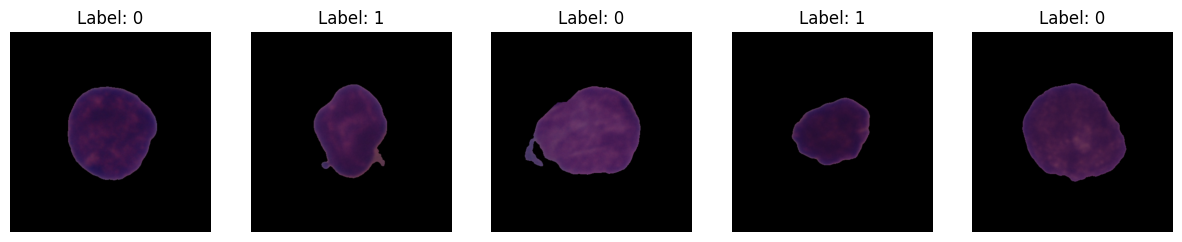

In [2]:
def create_df(dataset, sample_size):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for i, filename in enumerate(filenames):
            if i >= sample_size:
                break
            
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths, 
                       'Label': labels})
    
    return df

train_dir = "C-NMC_Leukemia/training_data/"
df = create_df(train_dir, 500)

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))  
print("Number of validation samples: %d" % len(valid_df.index))

sample_images=train_df.head(5)
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for i, (_, row) in enumerate(sample_images.iterrows()):
    img = mpimg.imread(row['Image Path'])
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {row['Label']}")
    axes[i].axis('off')

plt.show()

#### Display Model Performance

In [3]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

#### Confusion Matrix

In [17]:
def show_conf_matrix(model, test_df, test_gen):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=0)

    # Get unique labels from the DataFrame
    unique_labels = test_df['Label'].unique()

    # Create a dictionary mapping class indices to class labels
    label_dict = {i: label for i, label in enumerate(unique_labels)}
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Get the ground truth labels from the DataFrame
    y_true = test_df['Label'].map({label: i for i, label in enumerate(unique_labels)}).values

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=unique_labels)

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

#### Evaluation Matrix

In [5]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

#### Show Images

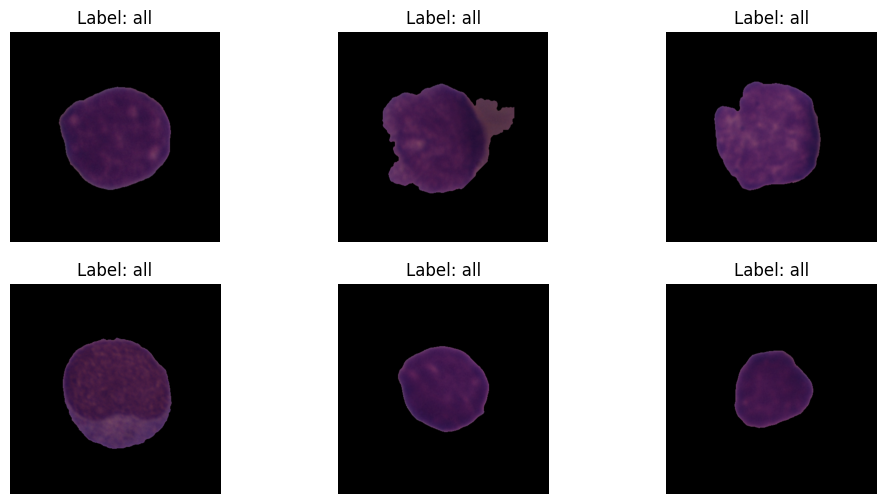

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Check the number of samples for 'hem' and 'all' classes
num_hem_samples = len(train_df[train_df['Label'] == 0])
num_all_samples = len(train_df[train_df['Label'] == 1])

# Ensure there are enough samples for both classes
if num_hem_samples >= 3 and num_all_samples >= 3:
    # Sample images for both classes
    hem_img = train_df[train_df['Label'] == 0].sample(3)
    all_img = train_df[train_df['Label'] == 1].sample(3)
    
    # Concatenate the sampled DataFrames
    sampled_df = pd.concat([hem_img, all_img])

    # Create a figure with subplots to show the images
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

    for i, row in enumerate(sampled_df.iterrows()):
        img = mpimg.imread(row[1]['Image Path'])
        ax = axes[i//3, i%3]
        ax.imshow(img)
        ax.axis('off')    
        if row[1]['Label'] == 'hem':
            ax.set_title(f"Label: hem")
        else:
            ax.set_title(f"Label: all")

    plt.show()
else:
    print("Not enough samples for both classes.")


#### Initializing Image Data Generators 

In [7]:
class_mode = 'raw'
batch_size = 32

train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)

train_gen = train_data_generator.flow_from_dataframe(
    train_df, 
    x_col='Image Path', 
    y_col='Label', 
    target_size=(224, 224), 
    class_mode=class_mode,  # Use 'binary' for binary classification
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_gen = valid_data_generator.flow_from_dataframe(
    valid_df, 
    x_col='Image Path', 
    y_col='Label', 
    target_size=(224, 224), 
    class_mode=class_mode, 
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

test_gen = valid_data_generator.flow_from_dataframe(
    test_df, 
    x_col='Image Path', 
    y_col='Label', 
    target_size=(224, 224), 
    class_mode=class_mode, 
    color_mode='rgb', 
    shuffle=False,  # Set shuffle to False for the test set
    batch_size=batch_size
)

Found 2100 validated image filenames.
Found 450 validated image filenames.
Found 450 validated image filenames.


# Classification Models

## EfficientNet B0

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adamax

# Set the input shape based on the EfficientNet model you choose
img_shape = (224, 224, 3)  # Adjust this based on the model's input size

# Load the EfficientNetB0 model
EfficientNetB0_base_model = EfficientNetB0(weights='imagenet', input_shape=img_shape, include_top=False)

# Freeze base model to keep pre-trained weights
EfficientNetB0_base_model.trainable = False

# Add custom top layers for binary classification
x = layers.GlobalAveragePooling2D()(EfficientNetB0_base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Use 1 neuron for binary classification


# Create the new model
EfficientNetB0_model = models.Model(EfficientNetB0_base_model.input, x, name="EfficientNetB0_model")

EfficientNetB0_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')]
)

EfficientNetB0_model.summary()


Model: "EfficientNetB0_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normaliza

#### Train Model

In [9]:
epochs = 15

history_EfficientNetB0_model = EfficientNetB0_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/15
66/66 [==============================] - 69s 918ms/step - loss: 0.7035 - accuracy: 0.4957 - recall: 0.4848 - precision: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/15
66/66 [==============================] - 63s 954ms/step - loss: 0.7063 - accuracy: 0.4843 - recall: 0.4990 - precision: 0.4847 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 3/15
66/66 [==============================] - 66s 1s/step - loss: 0.7000 - accuracy: 0.5100 - recall: 0.4914 - precision: 0.5104 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 4/15
66/66 [==============================] - 69s 1s/step - loss: 0.6993 - accuracy: 0.5171 - recall: 0.5381 - precision: 0.5165 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 5/15
66/66 [==============================] - 63s 960ms/step - loss: 0.7053 - accuracy: 0.4910 - rec

#### Evaluate Model

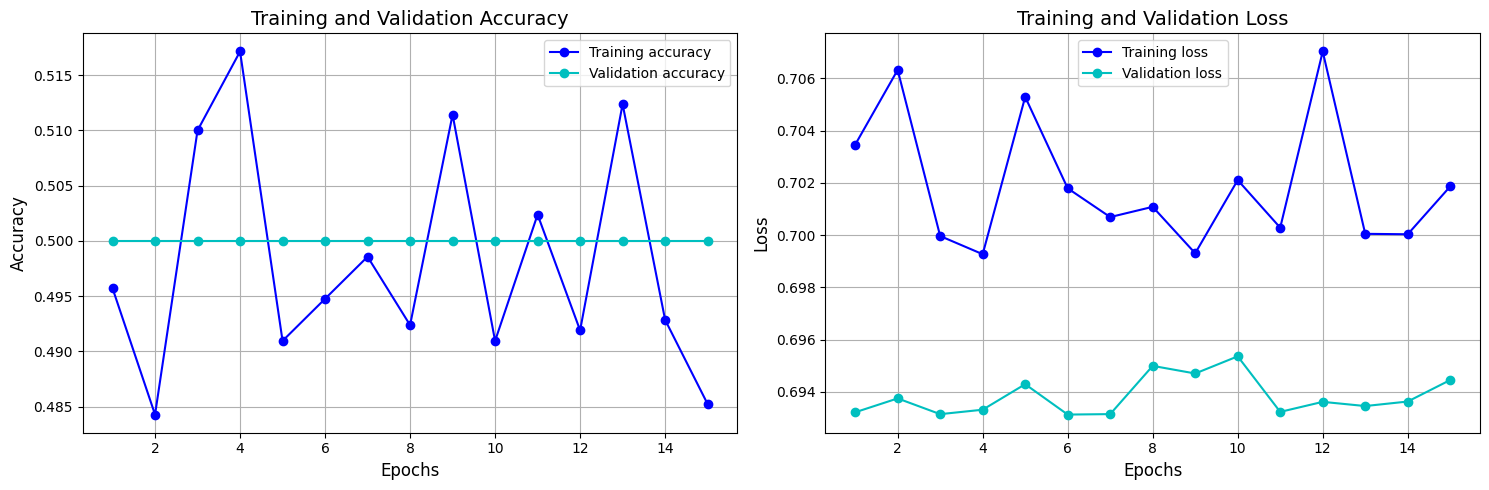

In [10]:
show_history_plot(history_EfficientNetB0_model.history)

In [18]:
EfficientNetB0_model.save('LeukEB0.h5')

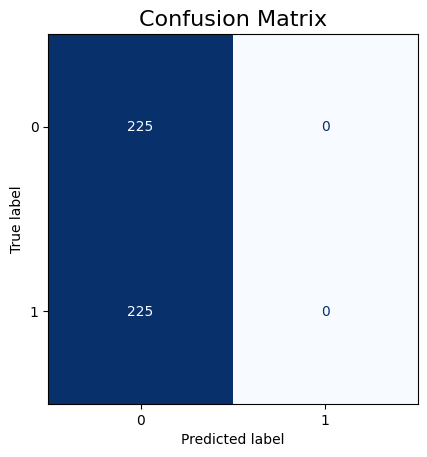

<Figure size 700x700 with 0 Axes>

In [22]:
def show_conf_matrix(model, test_df, test_gen):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=0)

    # Get unique labels from the DataFrame
    unique_labels = test_df['Label'].unique()

    # Create a dictionary mapping class indices to class labels
    label_dict = {i: label for i, label in enumerate(unique_labels)}
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Get the ground truth labels from the DataFrame
    y_true = test_df['Label'].map({label: i for i, label in enumerate(unique_labels)}).values

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=unique_labels)

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

# Call the function with the test_df and test_gen parameters
show_conf_matrix(EfficientNetB0_model, test_df, test_gen)
